In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
import tensorflow as tf
import tensorflow_hub as hub


In [54]:
df=pd.read_csv("/content/sample_data/wine-reviews.csv",usecols=["country","description","points","price","variety","winery"])

In [55]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [56]:
df=df.dropna(subset=["description","points"])

In [57]:
df.head()


,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


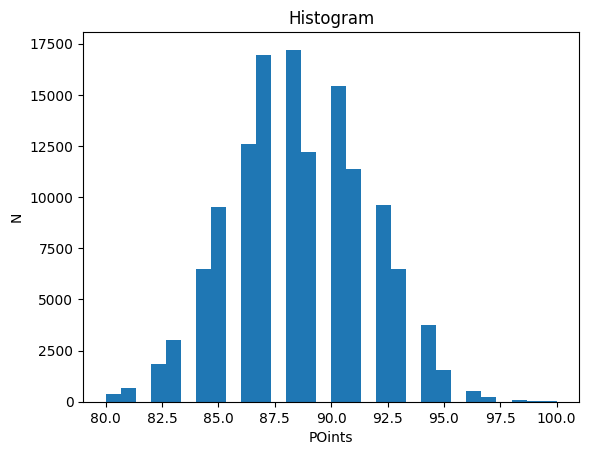

In [58]:
plt.hist(df.points,bins=30)
plt.title("Histogram")
plt.ylabel("N")
plt.xlabel("POints")
plt.show()

In [59]:
df["label"]=(df.points>=90).astype(int)
df=df[["description","label"]]

In [60]:
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [61]:
train,val,test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [62]:
len(train),len(val),len(test)

(103976, 12997, 12998)

In [63]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds=tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [64]:
train_data=df_to_dataset(train)
valid_data=df_to_dataset(val)
test_data=df_to_dataset(test)

In [65]:
#Embedding + Model
embedding="https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer=hub.KerasLayer(embedding,
                         dtype=tf.string,trainable=True)

In [66]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.03066431, -0.3468331 ,  0.17935753, ..., -0.04560895,
         0.09760346, -0.0419631 ],
       [ 0.27069163, -0.35917658, -0.27304438, ..., -0.2216971 ,
        -0.3280892 ,  0.06402896],
       [ 0.17180221, -0.14796104, -0.04430634, ...,  0.01688818,
        -0.2244055 ,  0.04364707],
       ...,
       [ 0.2058428 , -0.35086426,  0.14782754, ..., -0.06416471,
        -0.09678364, -0.11094686],
       [ 0.34561187, -0.14614122,  0.14368565, ...,  0.15985158,
        -0.18844508, -0.02167787],
       [ 0.32593006,  0.05303469,  0.05991159, ..., -0.23951618,
         0.06505209,  0.04414039]], dtype=float32)>

In [67]:
model=tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation="relu"))
model.add(tf.keras.layers.Dropout(0,4))
model.add(tf.keras.layers.Dense(16,activation="relu"))
model.add(tf.keras.layers.Dropout(0,4))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

In [68]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

In [69]:
model.evaluate(train_data)

102/102 [==============================] - 2s 14ms/step - loss: 0.7379 - accuracy: 0.3793


[0.7378681302070618, 0.3793182969093323]

In [70]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 13ms/step - loss: 0.7407 - accuracy: 0.3722


[0.7407222390174866, 0.37223973870277405]

In [ ]:
history=model.fit(train_data,epochs=10,validation_data=valid_data)

Epoch 1/10
102/102 [==============================] - 148s 1s/step - loss: 0.5681 - accuracy: 0.6857 - val_loss: 0.4269 - val_accuracy: 0.7999
Epoch 2/10
102/102 [==============================] - 142s 1s/step - loss: 0.3762 - accuracy: 0.8279 - val_loss: 0.3776 - val_accuracy: 0.8247
Epoch 3/10
102/102 [==============================] - 131s 1s/step - loss: 0.3303 - accuracy: 0.8542 - val_loss: 0.3695 - val_accuracy: 0.8297
Epoch 4/10
102/102 [==============================] - 132s 1s/step - loss: 0.3050 - accuracy: 0.8674 - val_loss: 0.3718 - val_accuracy: 0.8299
Epoch 5/10
102/102 [==============================] - 131s 1s/step - loss: 0.2845 - accuracy: 0.8776 - val_loss: 0.3767 - val_accuracy: 0.8290
Epoch 6/10
102/102 [==============================] - 146s 1s/step - loss: 0.2673 - accuracy: 0.8866 - val_loss: 0.3839 - val_accuracy: 0.8298
Epoch 7/10
102/102 [==============================] - 133s 1s/step - loss: 0.2518 - accuracy: 0.8944 - val_loss: 0.3890 - val_accuracy: 0.8310

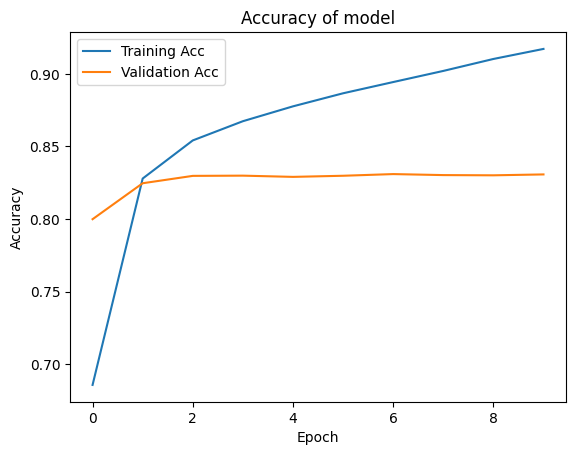

In [ ]:
plt.plot(history.history['accuracy'],label="Training Acc")
plt.plot(history.history['val_accuracy'],label="Validation Acc")

plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend()
plt.show()

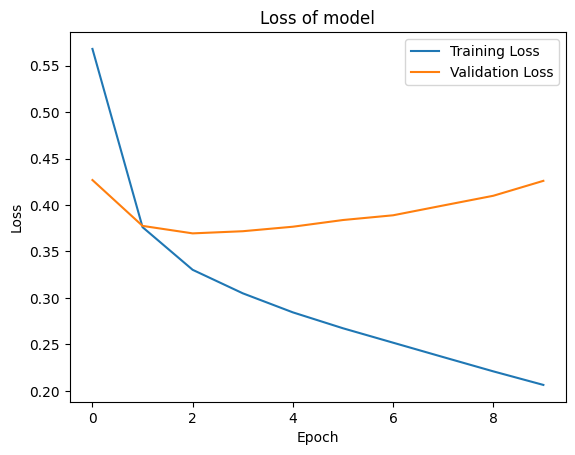

In [ ]:
plt.plot(history.history['loss'],label="Training Loss")
plt.plot(history.history['val_loss'],label="Validation Loss")

plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 2s 172ms/step - loss: 0.4231 - accuracy: 0.8343


[0.42309701442718506, 0.8342822194099426]

In [ ]:
#https://www.tensorflow.org/tutorials/structured_data/
#https://tfhub.dev/google/nnlm-en-dim50/2
#1hr 46min fcc